In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from eofs.xarray import Eof
import xcdat
from pathlib import Path
import pandas as pd

import functions.data_wrangling as dw
import annular_modes as am

# JRA55 SAM Indices

In [2]:
data_dir = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55/' 

jra55_data = os.path.join(data_dir, 'jra55_1979-2010_sh_eofs_all-time_daily_anom_lat20-85_100-1000hPa.nc')
jra55 = xr.open_mfdataset(jra55_data)

jra55_data_va = os.path.join(data_dir, 'jra55_1979-2010_sh_eofs_va_all-time_daily_anom_lat20-85_100-1000hPa.nc')
jra55_va = xr.open_mfdataset(jra55_data)

# jra55_data_mon = os.path.join(data_dir, 'jra55_1979-2010_eofs_all-time_mon_100-1000hPa.nc')
# jra55_mon = xr.open_mfdataset(jra55_data_mon)

# jra55_data_mon_va = os.path.join(data_dir, 'jra55_1979-2010_eofs_all-time_mon_va_100-1000hPa.nc')
# jra55_mon_va = xr.open_mfdataset(jra55_data_mon_va)

## Daily indices

### PC1 of vertically averaged zonal wind daily anomalies

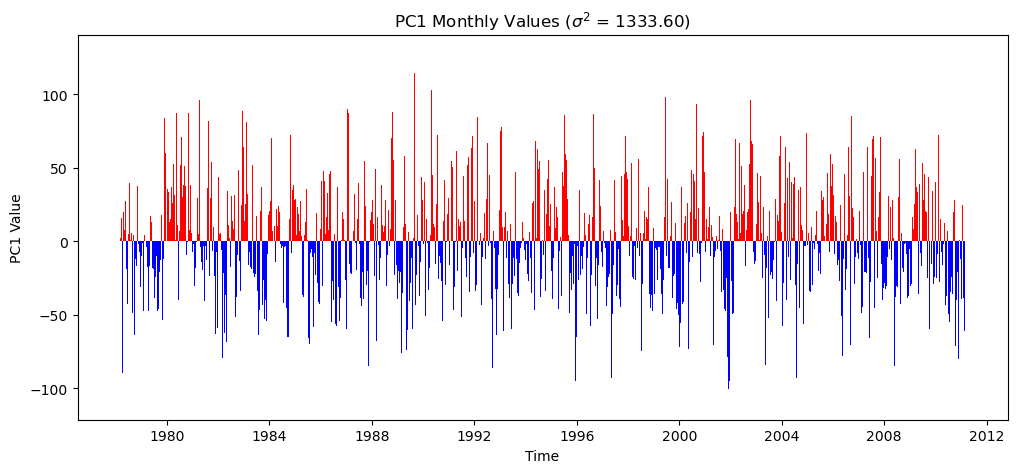

In [3]:
# Extract the pc1 data and select mode 0
pc1_va = jra55_va.pc1
data_va = pc1_va.sel(mode=0)
data_va = -data_va
variance_va = data_va.var()

colors = ['red' if v >= 0 else 'blue' for v in data_va.values]
width = data_va.time[1] - data_va.time[0]

plt.figure(figsize=(12, 5))
# Plot the data as a bar plot using matplotlib's plt.bar
plt.bar(data_va.time, data_va, color=colors, width=width)#, edgecolor='black')

# Optionally, add labels and title
plt.xlabel('Time')
plt.ylabel('PC1 Value')
plt.title(f'PC1 Monthly Values ($\sigma^2$ = {variance_va.values:.2f})')
plt.show()

# Reference SAM Index

This is 700hPa geopotential height anomalies, provided by NCEP NOAA.
- See [source](https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/aao/aao.shtml)

In [4]:
sam_path = '/home/links/ct715/data_storage/indices/SAM'
csv_file = 'norm.daily.aao.cdas.z700.19790101_current.csv'
sam_data = os.path.join(sam_path, csv_file)
df = pd.read_csv(sam_data)

# Suppose your DataFrame is named df and has columns: year, month, day, aao_index_cdas
# Create a datetime column
df['date'] = pd.to_datetime(df[['year','month','day']])
# df = df.loc['1978-03':'2011-02']
df = df[(df['date'] >= '1979-01-01') & (df['date'] <= '2010-12-31')]

# Sort by date just to be sure it's in ascending order
df = df.sort_values('date').reset_index(drop=True)
# df


## Correlations

In [5]:
# Create a mask that finds leap-day rows
leap_days = (df['date'].dt.month == 2) & (df['date'].dt.day == 29)
# Then invert that mask to keep everything else
df = df[~leap_days].copy()

# 1) Make sure df has a DateTimeIndex
df = df.set_index('date')  # Make 'date' the index
df.index = pd.to_datetime(df.index)  # Ensure it's a DateTimeIndex

# 2) Convert your pandas Series to an xarray DataArray
#    Let's say your PC1 is in df['pc1']:
pc1_da = df['aao_index_cdas'].to_xarray()  # pc1_da will be a 1D DataArray with dimension 'date'

# 3) Ensure your existing xarray DataArray 'da' has a matching time dimension
#    Optionally rename dimensions so both arrays share the same dimension name:
#    (some data might have 'time', the other might have 'date'; unify them)
pc1_da = pc1_da.rename({'date': 'time'})  
# Now pc1_da and da both have dimension 'time' (assuming 'da' was also 'time').
pc1_da['time'] = pc1_da['time'].dt.strftime('%Y-%m-%d')
sam = data_va.sel(time=slice('1979-01-01', '2010-12-31')) #.values
sam['time'] = sam['time'].dt.strftime('%Y-%m-%d')

# calculate correlation after ensuring both DataArrays have the same time dimension
pc1_da_aligned, da_aligned = xr.align(pc1_da, sam, join='inner')
r = xr.corr(pc1_da_aligned, da_aligned, dim='time')
print("Correlation:", r.values)

Correlation: -0.7941113454738727


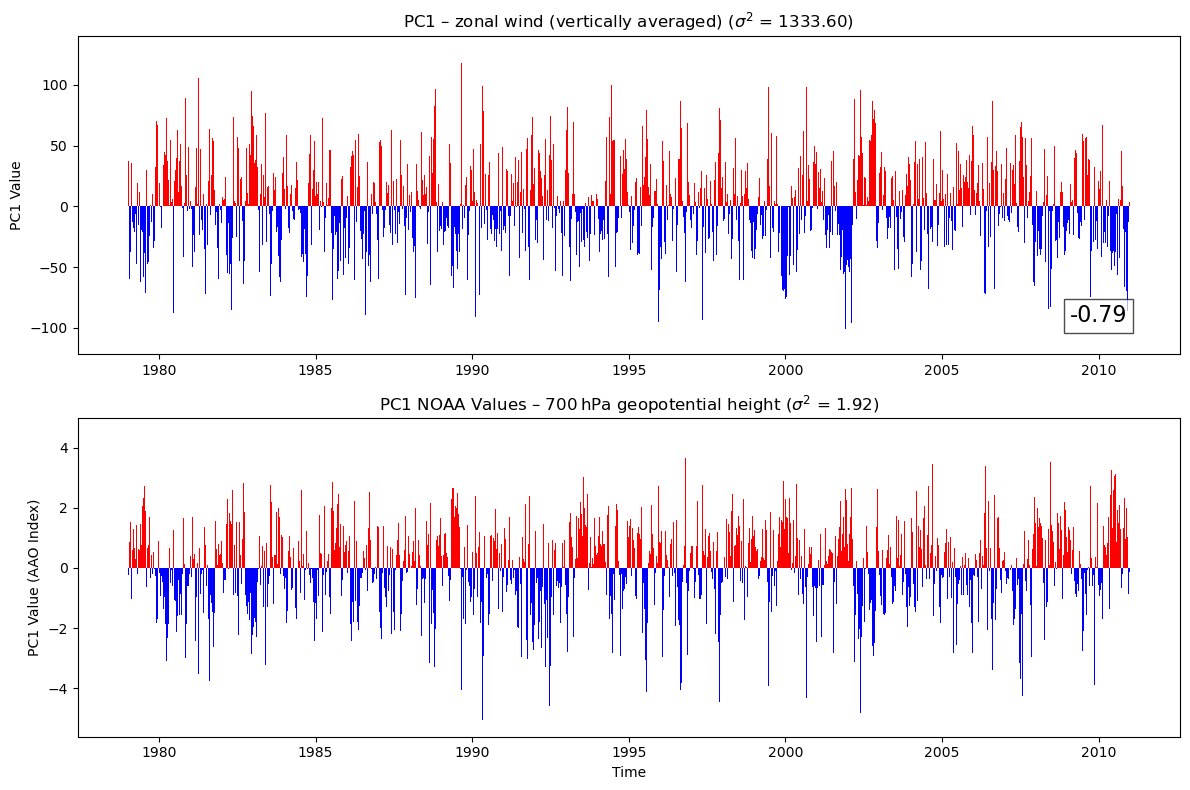

In [6]:
# ── Convert the coordinate once ───────────────────────────────
sam_times = pd.to_datetime(sam.time)        # -> dtype='datetime64[ns]'
sam_vals  = sam.values                      # y‑data

# A 1‑day bar looks good for daily data
bar_width = 1                               # units = “days” on a date axis

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

# ---- panel 1 -------------------------------------------------
colors = ['red' if v >= 0 else 'blue' for v in sam_vals]

ax1.bar(sam_times, sam_vals, color=colors, width=bar_width)
ax1.set_ylabel('PC1 Value')
ax1.set_title(f'PC1 – zonal wind (vertically averaged) ($\\sigma^2$ = {variance_va.values:.2f})')

ax1.text(0.9, 0.1,
         f'{r.values.round(2)}',
         transform=ax1.transAxes,
         fontsize=16,
         bbox=dict(facecolor='white', alpha=0.7))

# ---- panel 2 -------------------------------------------------
# Make sure the “time” column is already datetime64[ns]
pc1_times = pd.to_datetime(pc1_da['time'])
pc1_vals  = pc1_da.values
colors_df = ['red' if v >= 0 else 'blue' for v in pc1_vals]

if len(pc1_times) > 1:
    bar_width_df = (pc1_times[1] - pc1_times[0]).days
else:
    bar_width_df = 1

ax2.bar(pc1_times, pc1_vals, color=colors_df, width=bar_width_df)
ax2.set_xlabel('Time')
ax2.set_ylabel('PC1 Value (AAO Index)')
ax2.set_title(f'PC1 NOAA Values – 700 hPa geopotential height ($\\sigma^2$ = {pc1_da.var():.2f})')

# Optional: prettier date formatting
for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(mdates.YearLocator(5))   # tick every 5 years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x')

plt.tight_layout()
plt.show()


In [7]:
pc1_vals

array([-1.55630267, -0.88822687,  0.25526777, ...,  0.50683439,
        0.78998971,  0.70748442])

---

# Other timeframes
## Monthly averages

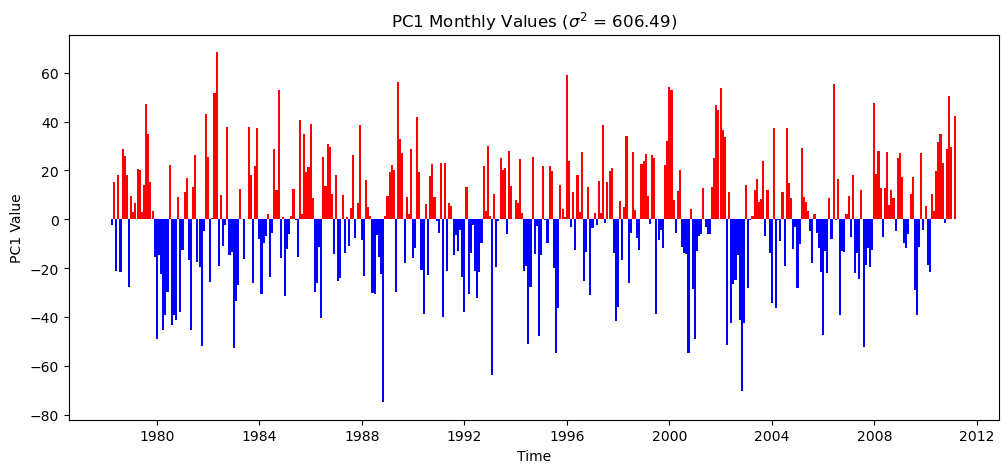

In [8]:
# Extract the pc1 data and select mode 0
jra55_mon = jra55.resample(time='1ME').mean('time')
pc1_mon = jra55_mon.pc1
data_mon = pc1_mon.sel(mode=0)
variance = data_mon.var()


# Create a list of colors: red for positive (or zero) values, blue for negative values.
colors = ['red' if value >= 0 else 'blue' for value in data_mon.values]

width = data_mon.time[1] - data_mon.time[0]

plt.figure(figsize=(12, 5))
# Plot the data as a bar plot using matplotlib's plt.bar
plt.bar(data_mon.time, data_mon, color=colors, width=width)#, edgecolor='black')

# Optionally, add labels and title
plt.xlabel('Time')
plt.ylabel('PC1 Value')
plt.title(f'PC1 Monthly Values ($\sigma^2$ = {variance.values:.2f})')
plt.show()

## Seasonal averages

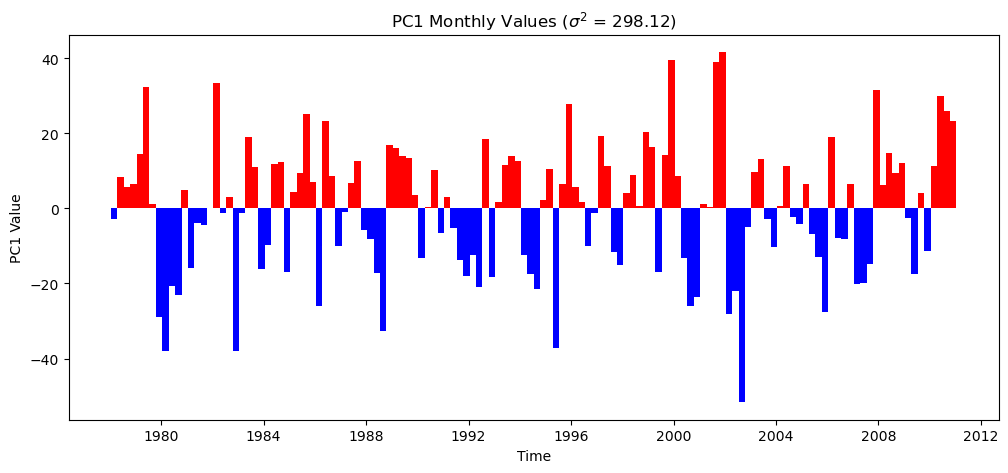

In [9]:
# Extract the pc1 data and select mode 0
jra55_szn = jra55.resample(time='QS-DEC').mean('time')
pc1_szn = jra55_szn.pc1
seasonal_data = pc1_szn.sel(mode=0)
variance = seasonal_data.var()

# Create a list of colors: red for positive (or zero) values, blue for negative values.
colors = ['red' if value >= 0 else 'blue' for value in seasonal_data.values]

width = seasonal_data.time[1] - seasonal_data.time[0]

plt.figure(figsize=(12, 5))
# Plot the data as a bar plot using matplotlib's plt.bar
plt.bar(seasonal_data.time, seasonal_data, color=colors, width=width)#, edgecolor='black')

# Optionally, add labels and title
plt.xlabel('Time')
plt.ylabel('PC1 Value')
plt.title(f'PC1 Monthly Values ($\sigma^2$ = {variance.values:.2f})')
plt.show()

In [10]:
jra55_1y = jra55.resample(time='1YE').mean('time')
jra55_1y

<xarray.Dataset> Size: 200kB
Dimensions:             (time: 34, mode: 1, level: 27, lat: 27)
Coordinates:
  * mode                (mode) int64 8B 0
  * level               (level) float64 216B 100.0 125.0 150.0 ... 975.0 1e+03
  * lat                 (lat) float64 216B -20.0 -22.5 -25.0 ... -82.5 -85.0
  * time                (time) datetime64[ns] 272B 1978-12-31 ... 2011-12-31
Data variables:
    eofs                (time, mode, level, lat) float64 198kB dask.array<chunksize=(1, 1, 27, 27), meta=np.ndarray>
    pc1                 (time, mode) float64 272B dask.array<chunksize=(1, 1), meta=np.ndarray>
    variance_fractions  (time, mode) float64 272B dask.array<chunksize=(1, 1), meta=np.ndarray>

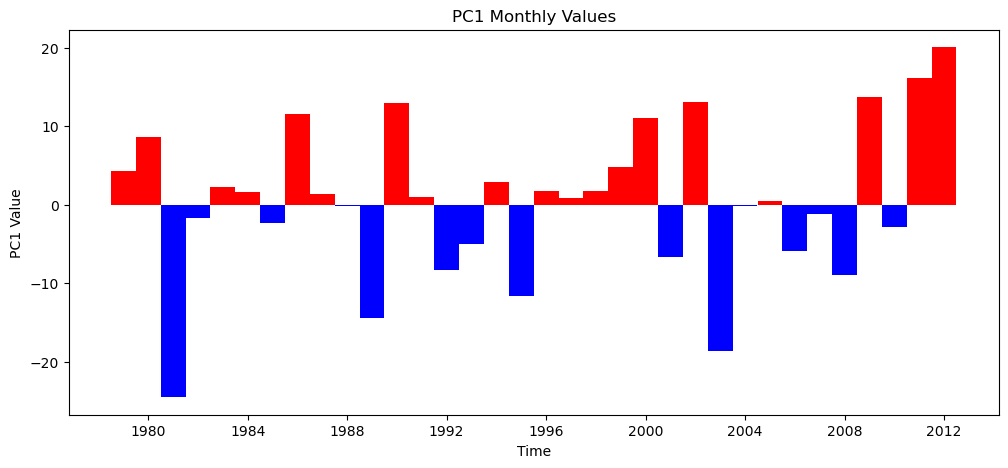

In [11]:
# Extract the pc1 data and select mode 0
annual_data = jra55_1y.pc1.sel(mode=0)

# Create a list of colors: red for positive (or zero) values, blue for negative values.
colors = ['red' if value >= 0 else 'blue' for value in annual_data.values]

width = annual_data.time[1] - annual_data.time[0]

plt.figure(figsize=(12, 5))
# Plot the data as a bar plot using matplotlib's plt.bar
plt.bar(annual_data.time, annual_data, color=colors, width=width)#, edgecolor='black')

# Optionally, add labels and title
plt.xlabel('Time')
plt.ylabel('PC1 Value')
plt.title('PC1 Monthly Values')
plt.show()